# Table of Contents
 <p><div class="lev1"><a href="#Modules,-functions,-results,-variables"><span class="toc-item-num">1&nbsp;&nbsp;</span>Modules, functions, results, variables</a></div><div class="lev1"><a href="#CRM-level-vertical-velocity"><span class="toc-item-num">2&nbsp;&nbsp;</span>CRM-level vertical velocity</a></div><div class="lev2"><a href="#Check-that-the-mean-profiles-match-the-previous-calculation"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Check that the mean profiles match the previous calculation</a></div><div class="lev3"><a href="#Vertical-velocity"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Vertical velocity</a></div><div class="lev3"><a href="#Rho"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span>Rho</a></div><div class="lev3"><a href="#Omega"><span class="toc-item-num">2.1.3&nbsp;&nbsp;</span>Omega</a></div><div class="lev2"><a href="#Look-at-individual-vertical-velocity-profiles"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Look at individual vertical velocity profiles</a></div><div class="lev2"><a href="#Look-at-individual-omega-profiles"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Look at individual omega profiles</a></div><div class="lev2"><a href="#PDF"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>PDF</a></div>

# Modules, functions, results, variables

Modules

In [127]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from mpl_toolkits.basemap import Basemap
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import gridspec
from netCDF4 import Dataset
from math import *
import glob
import string
import re
from datetime import date, time, datetime
from pprint import pprint
import sys,os
import csv
import pandas as pd
import pickle
import matplotlib.transforms as mtransforms

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Paths

In [2]:
# Add ../functions to system path
currentpath = %pwd
currentpath = str(currentpath)
##-- In a python script do the following instead:
##-- currentpath = os.path.dirname(os.path.realpath(__file__))
sys.path.insert(0,currentpath[:currentpath.rfind('/')+1]+'functions')

## Fixed data files input directory
inputdir_fx = '/Users/bfildier/Data/preprocessed/allExperiments/fx'
## Dataframe input directory
# resultdir = os.path.join(os.path.dirname(currentpath),'results')
resultdir = os.path.join(os.path.dirname(currentpath),'results/fullResults')
## Maps (2D tropical data files) input directory
inputdir_maps = os.path.join(os.path.dirname(currentpath),'inputs/forMaps')
inputdir_processed = os.path.join(os.path.dirname(currentpath),'inputs/fullDataPreprocessed')
inputdir_results = os.path.join(os.path.dirname(currentpath),'results')

##-- Output directories --##
## Figures
figdir = os.path.join(os.path.dirname(currentpath),'figures/fullResults')


Graphical parameters

In [3]:
###--- Set up graphical parameters ---###

##-- Figure setup --##
plt.rcParams.update({'axes.labelsize': 'x-large',
                     'axes.titlesize': 'x-large',
                     'xtick.labelsize': 'large',
                     'ytick.labelsize': 'large',
                     'figure.titlesize': 'xx-large',
                     'figure.subplot.top': '0.87',
                     'figure.subplot.wspace': '0.3',
                     'figure.subplot.hspace': '0.3',
                     'legend.fontsize':'medium'})

##-- Load colors for plots --##
colorfile = os.path.join(currentpath,'colorsAndTypes.pickle')
with open(colorfile,'rb') as handle:
    col = pickle.load(handle)
    lt = pickle.load(handle)
    pal = pickle.load(handle)
    lw = pickle.load(handle)
    dashes = pickle.load(handle)
    mark = pickle.load(handle)
    cmaps = pickle.load(handle)

Own modules and functions

In [4]:
from importingData import *
from extremeScaling import *
from thermodynamics import *
from thermo_funcs import *
from thermo_constants import *

Additional functions

In [5]:
###--- Functions ---### 

## Importing the results into directories of dataframes
def getStatDataFrame(stat,compsets,experiments,subsets,resultdir):
    
    """Import data frames in the for of embedded dictionaries.
    Output can be called as such: result[compset][experiment][subset]
    """
    
    stats_ok = ("pr_quantile_IL","pr_density_IL","pr_jointDensity_IL",
                "var2D_mean","var2D_meanAtQ",
                "var3D_meanProfile","var3D_meanProfileAtQ")
    df = {}
    if stat in stats_ok:
        for compset in compsets:
            df[compset] = {}
            for experiment in experiments:
                df[compset][experiment] = {}
                for subset in subsets_for_comp[compset]:
#                     if compset == "FAMIPC5" and subset == "mfzero":
#                         continue
                    csvfile = "%s_%s_%s_%s.csv"%(stat,compset,experiment,subset)
                    if stat in ("var2D_meanAtQ","var3D_meanProfileAtQ","pr_jointDensity_IL"):
                        df[compset][experiment][subset] = pd.read_csv(os.path.join(resultdir,csvfile),
                                                                      header=[0,1,2], skipinitialspace=True)
#                     elif stat == "pr_jointDensity_IL":
#                         df_jd = pd.read_csv(os.path.join(resultdir,csvfile))
#                         df_jd = df_jd.set_index(df_jd.columns[0])
#                         df[compset][experiment][subset] = df_jd
                    else:
                        df[compset][experiment][subset] = pd.read_csv(os.path.join(resultdir,csvfile))
    else:
        print "Warning: file handle not known."
        print "Should be one of the following:",stats_ok
    return df


## Get vertical profiles for plotting
def getAllProfiles(varids,pr_id,Q_id,df_mean,df_prof,computeP):
    
    ps_id, t_id, q_id, relhum_id, omega_id, w_id = varids
        
    ## Get surface values
    pres_s = df_mean[ps_id][pr_id][Q_id][0]
        
    if omega_id == 'OMEGA':

        ## Get existing profiles
        temp = df_prof[t_id][pr_id][Q_id]
        omega = df_prof[omega_id][pr_id][Q_id]
        relhum = df_prof[relhum_id][pr_id][Q_id]
        spechum = df_prof[q_id][pr_id][Q_id]
        
        ## Compute missing profiles
        pres = computeP(pres_s)
        rho = airDensity(temp,pres,spechum)
        wspeed = np.divide(omega,-g*rho)
    
    else:    # CRM_PREC_IXX
        
        ## Get existing profiles
        temp = np.flipud(df_prof[t_id][pr_id][Q_id])
        wspeed = np.flipud(df_prof[w_id][pr_id][Q_id])
        
        ## Compute missing profiles
        pres = computeP(pres_s)
        
        #         spechum = np.flipud(df_prof[q_id][pr_id][Q_id])
        spechum = df_prof[q_id][pr_id][Q_id]
        
        rho = airDensity(temp,pres,spechum)
        omega = np.multiply(wspeed,-g*rho)
        relhum = np.array([np.nan]*pres.size)
        
    ## Store all profiles and return
    profiles = (pres,temp,spechum,relhum,rho,omega,wspeed)
    
    return profiles


## Get vertical profiles for scaling
def getProfilesForScaling(varids,pr_id,Q_id,df_mean,df_prof,computeP,q_id='Q'):
    
    ps_id, t_id, omega_id, w_id = varids
        
    ## Get surface values
    pres_s = df_mean[ps_id][pr_id][Q_id][0]
        
    if pr_id == "PRECT":

        ## Get existing profiles
        temp = df_prof[t_id][pr_id][Q_id]
        omega = df_prof[omega_id][pr_id][Q_id]
        spechum = df_prof[q_id][pr_id][Q_id]
        
        ## Compute missing profiles
        pres = computeP(pres_s)
        rho = airDensity(temp,pres,spechum)
        wspeed = np.divide(omega,-g*rho)
        
    else:    # CRM_PREC_IXX
        
        ## Get existing profiles
        temp = np.flipud(df_prof[t_id][pr_id][Q_id])
        wspeed = np.flipud(df_prof[w_id][pr_id][Q_id])
        spechum = df_prof[q_id][pr_id][Q_id]
        
        ## Compute missing profiles
        pres = computeP(pres_s)
        rho = airDensity(temp,pres,spechum)
        omega = np.multiply(wspeed,-g*rho)

    ## Compute scaling profiles and return
    profiles = pres_sc,temp_sc,qvs_sc,omega_sc,rho_sc,wspeed_sc = profilesForScalingFromMeanProfilesAtQ(pres,temp,omega,rho,wspeed)
    
    return profiles

## Read the 2D arrays from string format in dataframe
def readJointDensityDataFrame(df,id1,id2):
    H = df[id1][id2]
    H = re.sub('[ \s\t\n]+', ' ',H)
    H = re.sub('\[[ ]*','',H)
    H = H.replace(' ',',')
    H = H.replace('],',' ')
    H = H.replace(']]','')
    H = H.split(' ')
    H = np.array([map(float,h.split(',')) for h in H])
    return H

def filter2D(m):
    def add2D(m):        
        mout = 4*m.copy()
        mout[:-1,:] = mout[:-1,:] + m[1:,:]
        mout[:,:-1] = mout[:,:-1] + m[:,1:]
        mout[1:,:] = mout[1:,:] + m[:-1,:]
        mout[:,1:] = mout[:,1:] + m[:,:-1]
        return mout
    return np.divide(add2D(m),add2D(np.ones(m.shape)))

def normalizeJointDensity(H,weights):
    n = weights.size
    H_norm = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            h = H[i,j]/np.interp((i+j)/2.,range(n),weights)
            if h is not None:
                H_norm[i,j] = h
    return H_norm

def normalizeJointDensity2(H):
    ## Define weights by summing along cross diagonals
    n = np.min(H.shape)
    weights = {}
    n_w = {}
    for i in range(n):
        for j in range(n):
            w_id = str((i+j)/2.)
            if w_id in weights.keys():
                weights[w_id] += H[i,j]
                n_w[w_id] += 1
            else:
                weights[w_id] = H[i,j]
                n_w[w_id] = 1
#     ## Define weights by summing along axis 0
#     weights = H.sum(axis=1)
#     n = weights.size
    ## Compute normalized 2D densities
    H_norm = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            w_id = str((i+j)/2.)
            h = H[i,j]/weights[w_id]
#             h = H[i,j]/weights[w_id]/n_w[w_id]
#             h = H[i,j]/weights[i]
            if h is not None:
                H_norm[i,j] = h
    return H_norm


def getSubset(subsetName,landmask,ndays=1):

    if subsetName == "ocean":
        # Define subset of points over ocean
        subset_pts = np.logical_not(landmask)
    elif subsetName == "land":
        # Define subset of points over land
        subset_pts = np.array(landmask[:],dtype=bool)
    elif subsetName == "tropics":
        subset_pts = np.ones(landmask.shape,dtype=bool)

    subset_pts = np.vstack([[subset_pts]]*ndays)    
    return subset_pts

## Filter before plotting
def filter121(var1D):
    var1D = np.array(var1D,dtype=float)
    var_filt = 0.25*var1D[:-2] + 0.5*var1D[1:-1] + 0.25*var1D[2:]
    return np.hstack([np.array(np.nan),var_filt,np.array(np.nan)])

In [6]:
# Import convective-scale CRM-W-IXX at location or precipitation extremes
def importCRMWatQ(pr_id,area_id,q_id,experiment):
    w_id = "CRM_W_%s_%s_%s"%(area_id,pr_id,q_id)
    case = "bf_%s_%s"%(compset_SPCAM,experiment)
    inputdir = os.path.join(inputdir_processed,case,'day','merged')
#     inputdir = os.path.join(inputdir_processed,case)
    files = getInputfiles(w_id,inputdir)
    w_values = getVar(w_id,inputdir,inputfiles=files,concataxis=2)
    return w_values

# Import daily profiles of varid at location of precipitation extremes
def importVar3DAtQ(varid,pr_id,q_id,experiment):
    varAtQ_id = "%s_%s_%s"%(varid.replace('-','_'),pr_id,q_id)
    case = "bf_%s_%s"%(compset_SPCAM,experiment)
    inputdir = os.path.join(inputdir_processed,case,'day','merged')
#     inputdir = os.path.join(inputdir_processed,case)
    files = getInputfiles(varAtQ_id,inputdir)
    rho_values = getVar(varAtQ_id,inputdir,inputfiles=files,concataxis=2)
    return rho_values

## Filter before plotting
def filter121(var1D):
    var1D = np.array(var1D,dtype=float)
    var_filt = 0.25*var1D[:-2] + 0.5*var1D[1:-1] + 0.25*var1D[2:]
    return np.hstack([np.array(np.nan),var_filt,np.array(np.nan)])

Global variables and datasets

In [7]:
###--- Datasets ---###

## Dataset parameter sets and variable sets
compsets = ("FSPCAMm_AMIP","FAMIPC5")
experiments = ("piControl","abrupt4xCO2")
subsets = ("tropics","ocean","land","mfzero")
subsets_for_comp = dict(zip(compsets,(subsets,subsets[:-1])))

## Individual names
compset_SPCAM, compset_CAM5 = compsets
experiment_PI, experiment_4xCO2 = experiments
subset_all, subset_ocean, subset_land, subset_mf = subsets


##--- Related to scaling ---##

## Simulation vs. pr scaling
pr_types = ["simulated","scaling"]
## Contributions to fractional changes
# contributions = ["mass","thermo","dyn_mean","dyn_profile","pressure","non_linear","all"]
# contributions_labs = ["Mass","Thermodynamic",r"Mass flux",r"Profile shift","Pressure","Non linear","Sum"]
contributions = ["thermo","dyn_mean","dyn_mean_th","dyn_mean_dyn","dyn_profile","non_linear","all"]
contributions_labs = ["Thermodynamic",r"Mass flux",r"Mass flux ($\Delta \rho$)",r"Mass flux ($\Delta w$)",
                      r"Profile shift","Non linear","Sum"]
contributions_labels = dict(zip(contributions,contributions_labs))

###--- Variables ids ---###

## All pr ids
pr_ids = ["PRECT","CRM_PREC_I90","CRM_PREC_I75","CRM_PREC_I50","CRM_PREC_I25","CRM_PREC_I10"]
gcm_pr_id = pr_ids[0]
crm_pr_ids = pr_ids[1:]
pr_ids_for_compset = {compsets[0]:pr_ids, compsets[1]:[gcm_pr_id]}

area_id_root = "PRECAREA_"
area_ids = [area_id_root+crm_pr_id.split('_')[-1] for crm_pr_id in crm_pr_ids]

frac_id_root = "PRECFRAC_"
frac_ids = [frac_id_root+crm_pr_id.split('_')[-1] for crm_pr_id in crm_pr_ids]

## Define IDs of variables required for plotting profiles
varids_for_profiles = {"PRECT":('PS','T','Q','RELHUM','OMEGA','W')}
for f in [90,75,50,25,10]:
#     varids_for_profiles["CRM_PREC_I%s"%str(f)] = ('PS','CRM_T_I%s'%str(f),'CRM_QC_I%s'%str(f),'CRM_H_I%s'%str(f),
#                                            'CRM_OMEGA_I%s'%str(f),'CRM_W_I%s'%str(f))
    varids_for_profiles["CRM_PREC_I%s"%str(f)] = ('PS','CRM_T_I%s'%str(f),'Q','CRM_H_I%s'%str(f),
                                           'CRM_OMEGA_I%s'%str(f),'CRM_W_I%s'%str(f))

## Define IDs of variables required for computing scaling
varids_for_scaling = {"PRECT":('PS','T','OMEGA','W')}
for f in [90,75,50,25,10]:
    varids_for_scaling["CRM_PREC_I%s"%str(f)] = ('PS','CRM_T_I%s'%str(f),'CRM_OMEGA_I%s'%str(f),'CRM_W_I%s'%str(f))

## Define percentile values
Q_IL_ext = np.array([90.0, 92.0567, 93.6904, 94.9881, 96.0189, 96.8377, 97.4881, 98.0047, 98.4151, 98.7411,
        99.0, 99.2057, 99.369, 99.4988, 99.6019, 99.6838, 99.7488, 99.8005, 99.8415, 99.8741,
        99.9, 99.9206, 99.9369, 99.9499, 99.9602, 99.9684, 99.9749, 99.98, 99.9842, 99.9874,
        99.99, 99.9921, 99.9937, 99.995, 99.996, 99.9968, 99.9975, 99.998, 99.9984, 99.9987,99.999])
Qs = [90.,96.8377,99.,99.6838,99.9,99.9684,99.99,99.9968]
Q_ids = ['90.0','96.8377','99.0','99.6838','99.9','99.9684','99.99','99.9968']

###--- Legends, titles and labels ---###
    
## Corresponding legend labels
compset_labs = ["SPCAM","CAM5"]
compset_labels = dict(zip(compsets,compset_labs))

exp_labs = ["Pre-industrial","4xCO2"]
exp_labels = dict(zip(experiments,exp_labs))

subset_labs = ["Tropics","Tropical oceans","Tropical land","Zero mass flux"]
subset_labels = dict(zip(subsets,subset_labs))

pr_labs = [r"$P(GCM)$",r"$P(CRM)$ largest $90\%$",r"$P(CRM)$ largest $75\%$",r"$P(CRM)$ largest $50\%$",
             r"$P(CRM)$ largest $25\%$",r"$P(CRM)$ largest $10\%$"]
pr_labels = dict(zip(pr_ids,pr_labs))
pr_labs_short = [r"$P(GCM)$",r"${\left[P(CRM)\right]}^{90\%}$",r"${\left[P(CRM)\right]}^{75\%}$",
                 r"${\left[P(CRM)\right]}^{50\%}$",
             r"${\left[P(CRM)\right]}^{25\%}$",r"${\left[P(CRM)\right]}^{10\%}$"]
pr_labels_short = dict(zip(pr_ids,pr_labs_short))
pr_labs_veryshort = [r"$P_{GCM}$",r"$P_{CRM}^{90\%}$",r"$P_{CRM}^{75\%}$",
                 r"$P_{CRM}^{50\%}$",r"$P_{CRM}^{25\%}$",r"$P_{CRM}^{10\%}$"]
pr_labels_veryshort = dict(zip(pr_ids,pr_labs_veryshort))
pr_labs_vvshort = [r"$P_{GCM}$",r"$P_{CRM}$",r"$P_{CRM}$",r"$P_{CRM}$",r"$P_{CRM}$",r"$P_{CRM}$"]
pr_labels_vvshort = dict(zip(pr_ids,pr_labs_vvshort))


###--- Results and others ---###

## Vertical pressure coordinate function
lev_file = 'lev_fx_CESM111-SPCAM20_allExperiments_r0i0p0.nc'
computeP = getPressureCoordinateFunction(os.path.join(inputdir_fx,lev_file))

## Import all dataframes
df_quantile = getStatDataFrame("pr_quantile_IL",compsets,experiments,subsets,resultdir)
df_density2D = getStatDataFrame("pr_jointDensity_IL",compsets,experiments,subsets,resultdir)
df_mean = getStatDataFrame("var2D_mean",compsets,experiments,subsets,resultdir)
df_meanProfile = getStatDataFrame("var3D_meanProfile",compsets,experiments,subsets,resultdir)
df_meanAtQ = getStatDataFrame("var2D_meanAtQ",compsets,experiments,subsets,resultdir)
df_meanProfileAtQ = getStatDataFrame("var3D_meanProfileAtQ",compsets,experiments,subsets,resultdir)

# CRM-level vertical velocity

In [64]:
print "Importing vertical velocity profiles"

# set variables 
pr_ids_to_plot = ["CRM_PREC_I50"]
pr_id = "CRM_PREC_I50"
# area_id = "I50"
q_id = "999000"
q_ids_to_plot = [q_id]
area_id_to_plot = ["I50","O50"]

# Import all profiles
w_profiles = {}
for experiment in experiments:
    w_profiles[experiment] = {}
    for pr_id in pr_ids_to_plot:
        w_profiles[experiment][pr_id] = {}
        for q_id in q_ids_to_plot:
            w_profiles[experiment][pr_id][q_id] = {}
            for area_id in area_id_to_plot:
                w_id = 'CRM_W_%s'%area_id
                w_values = importCRMWatQ(pr_id,area_id,q_id,experiment)
#                 if w_values.shape[0] == 1:
#                 w_values = np.reshape(w_values,w_values.shape[1:])
                w_values = np.flipud(np.reshape(w_values,w_values.shape[1:]))
                w_profiles[experiment][pr_id][q_id][w_id] = w_values

Importing vertical velocity profiles


In [65]:
print "Importing density profiles"

# set variables 
pr_ids_to_plot = ["CRM_PREC_I50"]
pr_id = "CRM_PREC_I50"
q_id = "999000"
q_ids_to_plot = [q_id]
rho_id = "RHO_MESO"

# Import all profiles
rho_profiles = {}
for experiment in experiments:
    rho_profiles[experiment] = {}
    for pr_id in pr_ids_to_plot:
        rho_profiles[experiment][pr_id] = {}
        for q_id in q_ids_to_plot:
            rho_profiles[experiment][pr_id][q_id] = {}
            rho_values = importVar3DAtQ(rho_id,pr_id,q_id,experiment)
#                 if w_values.shape[0] == 1:
            rho_values = np.reshape(rho_values,rho_values.shape[1:])
            rho_profiles[experiment][pr_id][q_id][rho_id] = rho_values

Importing density profiles


In [66]:
print "Compute omega profiles"

omega_profiles = {}
for experiment in w_profiles.keys():
    omega_profiles[experiment] = {}
    for pr_id in w_profiles[experiment].keys():
        omega_profiles[experiment][pr_id] = {}
        for q_id in w_profiles[experiment][pr_id].keys():
            omega_profiles[experiment][pr_id][q_id] = {}
            for w_id in w_profiles[experiment][pr_id][q_id].keys():
                omega_id = "OMEGA_%s"%w_id
                rho_values = rho_profiles[experiment][pr_id][q_id][rho_id]
                w_values = w_profiles[experiment][pr_id][q_id][w_id]
                omega_profiles[experiment][pr_id][q_id][omega_id] = -g*np.multiply(rho_values,w_values)

Compute omega profiles


## Check that the mean profiles match the previous calculation

### Vertical velocity

In [11]:
print "Compute mean vertical velocity profiles..."
pr_id = "CRM_PREC_I50"
area_id = "I50"
q_id = "999000"
Q_id = "99.9"
w_id = "CRM_W_%s"%area_id
w_profile_PI_mean = w_profiles[experiment_PI][pr_id][q_id][w_id].mean(axis=1)
w_profile_4xCO2_mean = w_profiles[experiment_4xCO2][pr_id][q_id][w_id].mean(axis=1)

Compute mean vertical velocity profiles...


In [12]:
print "Get mean profiles previously computed..."
w_id = "CRM_W_%s"%area_id
ps_id = "PS"
w_PI = np.flipud(df_meanProfileAtQ[compset_SPCAM][experiment_PI][subset_all][w_id][pr_id][Q_id])
w_4xCO2 = np.flipud(df_meanProfileAtQ[compset_SPCAM][experiment_4xCO2][subset_all][w_id][pr_id][Q_id])
ps_PI = df_meanAtQ[compset_SPCAM][experiment_PI][subset_all][ps_id][pr_id][Q_id][0]
p_PI = computeP(ps_PI)
ps_4xCO2 = df_meanAtQ[compset_SPCAM][experiment_4xCO2][subset_all][ps_id][pr_id][Q_id][0]
p_4xCO2 = computeP(ps_4xCO2)

Get mean profiles previously computed...


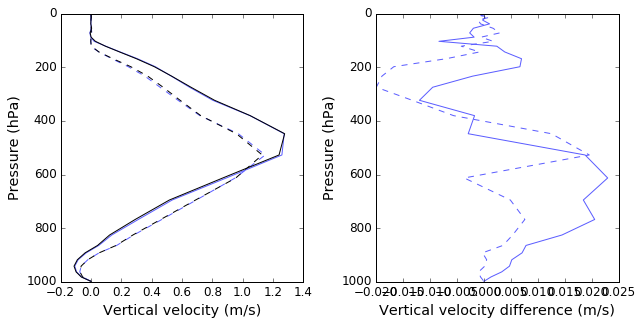

In [13]:
fig, (ax0,ax1) = plt.subplots(ncols=2,nrows=1,figsize=(10,5))

pr_ids_to_plot = ["CRM_PREC_I50"]

labels = {experiment_PI:"SPCAM_CTRL",experiment_4xCO2:"SPCAM_4xCO2"}

ax0.plot(w_profile_PI_mean,p_PI/100.,'--',c=col[pr_id])
ax0.plot(w_PI,p_PI/100.,'k--')
ax0.plot(w_profile_4xCO2_mean,p_4xCO2/100.,c=col[pr_id])
ax0.plot(w_4xCO2,p_4xCO2/100.,'k')
ax0.invert_yaxis()

ax1.plot(w_profile_PI_mean-w_PI,p_PI/100.,'--',c=col[pr_id])
ax1.plot(w_profile_4xCO2_mean-w_4xCO2,p_4xCO2/100.,c=col[pr_id])
ax1.invert_yaxis()

ax0.set_xlabel(r'Vertical velocity (m/s)')
ax0.set_ylabel(r'Pressure (hPa)')
ax1.set_xlabel(r'Vertical velocity difference (m/s)')
ax1.set_ylabel(r'Pressure (hPa)')

plt.show()


### Rho

In [16]:
print "Compute mean rho profiles..."
pr_id = "CRM_PREC_I50"
area_id = "I50"
q_id = "999000"
Q_id = "99.9"
rho_id = "RHO_MESO"
rho_profile_PI_mean = rho_profiles[experiment_PI][pr_id][q_id][rho_id].mean(axis=1)
rho_profile_4xCO2_mean = rho_profiles[experiment_4xCO2][pr_id][q_id][rho_id].mean(axis=1)

Compute mean rho profiles...


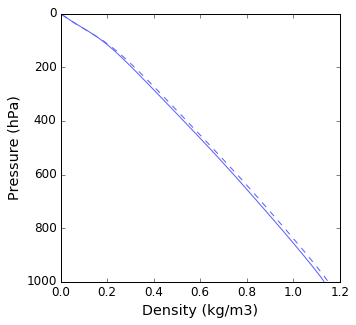

In [17]:
fig, (ax0) = plt.subplots(ncols=1,nrows=1,figsize=(5,5))

pr_ids_to_plot = ["CRM_PREC_I50"]

labels = {experiment_PI:"SPCAM_CTRL",experiment_4xCO2:"SPCAM_4xCO2"}

ax0.plot(rho_profile_PI_mean,p_PI/100.,'--',c=col[pr_id])
ax0.plot(rho_profile_4xCO2_mean,p_4xCO2/100.,c=col[pr_id])
ax0.invert_yaxis()

ax0.set_xlabel(r'Density (kg/m3)')
ax0.set_ylabel(r'Pressure (hPa)')

plt.show()


### Omega

In [18]:
print "Compute mean omega velocity profiles..."
pr_id = "CRM_PREC_I50"
area_id = "I50"
q_id = "999000"
Q_id = "99.9"
w_id = "CRM_W_%s"%area_id
omega_id = "OMEGA_%s"%w_id
omega_profile_PI_mean = omega_profiles[experiment_PI][pr_id][q_id][omega_id].mean(axis=1)
omega_profile_4xCO2_mean = omega_profiles[experiment_4xCO2][pr_id][q_id][omega_id].mean(axis=1)

Compute mean omega velocity profiles...


In [19]:
print "Get mean profiles previously computed..."
ps_id = "PS"
omega_PI = df_meanProfileAtQ[compset_SPCAM][experiment_PI][subset_all][omega_id][pr_id][Q_id]
omega_4xCO2 = df_meanProfileAtQ[compset_SPCAM][experiment_4xCO2][subset_all][omega_id][pr_id][Q_id]
ps_PI = df_meanAtQ[compset_SPCAM][experiment_PI][subset_all][ps_id][pr_id][Q_id][0]
p_PI = computeP(ps_PI)
ps_4xCO2 = df_meanAtQ[compset_SPCAM][experiment_4xCO2][subset_all][ps_id][pr_id][Q_id][0]
p_4xCO2 = computeP(ps_4xCO2)

Get mean profiles previously computed...


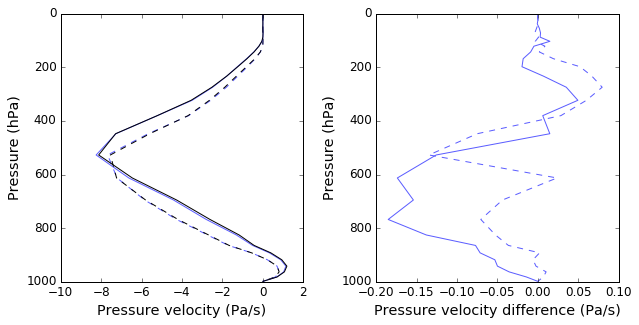

Compute the D1 contribution:
0.000299512343298
Ps(PI) = 99827.8801359
Ps(4xCO2) = 99836.9372103


In [26]:
fig, (ax0,ax1) = plt.subplots(ncols=2,nrows=1,figsize=(10,5))

pr_ids_to_plot = ["CRM_PREC_I50"]

labels = {experiment_PI:"SPCAM_CTRL",experiment_4xCO2:"SPCAM_4xCO2"}

ax0.plot(omega_profile_PI_mean,p_PI/100.,'--',c=col[pr_id])
ax0.plot(omega_PI,p_PI/100.,'k--')
ax0.plot(omega_profile_4xCO2_mean,p_4xCO2/100.,c=col[pr_id])
ax0.plot(omega_4xCO2,p_4xCO2/100.,'k')
ax0.invert_yaxis()

ax1.plot(omega_profile_PI_mean-omega_PI,p_PI/100.,'--',c=col[pr_id])
ax1.plot(omega_profile_4xCO2_mean-omega_4xCO2,p_4xCO2/100.,c=col[pr_id])
ax1.invert_yaxis()

ax0.set_xlabel(r'Pressure velocity (Pa/s)')
ax0.set_ylabel(r'Pressure (hPa)')
ax1.set_xlabel(r'Pressure velocity difference (Pa/s)')
ax1.set_ylabel(r'Pressure (hPa)')

plt.show()

print "Compute the D1 contribution:"

omega_for_contrib_PI = omega_profile_PI_mean.copy()
omega_for_contrib_PI[omega_for_contrib_PI>0] = 0.
omega_for_contrib_4xCO2 = omega_profile_4xCO2_mean.copy()
omega_for_contrib_4xCO2[omega_for_contrib_4xCO2>0] = 0.
mf_PI = verticalPressureIntegral(p_PI,omega_for_contrib_PI)
mf_4xCO2 = verticalPressureIntegral(p_4xCO2,omega_for_contrib_4xCO2)

## Plot fractional change per unit temperature
ts_id = 'TS'
ts1 = df_mean[compset_SPCAM][experiments[0]][subset_all][ts_id][0]
ts2 = df_mean[compset_SPCAM][experiments[1]][subset_all][ts_id][0]
dts = ts2-ts1

print (mf_4xCO2/mf_PI - 1.)/100.*dts
print "Ps(PI) =",p_PI[-1]
print "Ps(4xCO2) =",p_4xCO2[-1]


In [30]:
print "Decompose the dynamic contribution D1 into a rho and W components"

# Prepare profiles
omega_for_contrib_PI = omega_profile_PI_mean.copy()
ind_dwndrafts_PI = omega_for_contrib_PI>0
omega_for_contrib_PI[ind_dwndrafts_PI] = 0.
omega_for_contrib_4xCO2 = omega_profile_4xCO2_mean.copy()
ind_dwndrafts_4xCO2 = omega_for_contrib_4xCO2>0
omega_for_contrib_4xCO2[ind_dwndrafts_4xCO2] = 0.
w_for_contrib_PI = w_profile_PI_mean.copy()
w_for_contrib_PI[ind_dwndrafts_PI] = 0.
w_for_contrib_4xCO2 = w_profile_4xCO2_mean.copy()
w_for_contrib_4xCO2[ind_dwndrafts_4xCO2] = 0.
rho_for_contrib_PI = rho_profile_PI_mean.copy()
rho_for_contrib_4xCO2 = rho_profile_4xCO2_mean.copy()

# column-integrated quantities
mf_PI = verticalPressureIntegral(p_PI,omega_for_contrib_PI)
mf_4xCO2 = verticalPressureIntegral(p_4xCO2,omega_for_contrib_4xCO2)
mf_wPI_rhoPI = -g*verticalPressureIntegralProduct(p_PI,w_for_contrib_PI,rho_for_contrib_PI)
mf_w4xCO2_rhoPI = -g*verticalPressureIntegralProduct(p_4xCO2,w_for_contrib_4xCO2,rho_for_contrib_PI)
mf_wPI_rho4xCO2 = -g*verticalPressureIntegralProduct(p_PI,w_for_contrib_PI,rho_for_contrib_4xCO2)

# Change in T_s
ts_id = 'TS'
ts1 = df_mean[compset_SPCAM][experiments[0]][subset_all][ts_id][0]
ts2 = df_mean[compset_SPCAM][experiments[1]][subset_all][ts_id][0]
dts = ts2-ts1

D1 = (mf_4xCO2/mf_PI - 1.)*100./dts
D1_rho = (mf_wPI_rho4xCO2-mf_wPI_rhoPI)/mf_PI*100./dts
D1_w = (mf_w4xCO2_rhoPI-mf_wPI_rhoPI)/mf_PI*100./dts

print 
print 'PI mass flux:', mf_PI
print '4xCO2 mass flux', mf_4xCO2
print 'D1 contribution:', D1
print
print 'rho PI mass flux:', mf_wPI_rhoPI
print 'rho 4xCO2 mass flux:', mf_wPI_rho4xCO2
print 'rho component:', D1_rho
print
print 'w PI mass flux:', mf_wPI_rhoPI
print 'w 4xCO2 mass flux:', mf_w4xCO2_rhoPI
print 'w component:', D1_w

Decompose the dynamic contribution D1 into a rho and W components

PI mass flux: -31822.2830108
4xCO2 mass flux -32047.973497
D1 contribution: 0.16793805226

rho PI mass flux: -31828.3177513
rho 4xCO2 mass flux: -31143.6694084
rho component: -0.509452175414

w PI mass flux: -31828.3177513
w 4xCO2 mass flux: -32865.0042364
w component: 0.771406504511


## Look at individual vertical velocity profiles 

Get all w profiles...
Get mean pressure profiles...


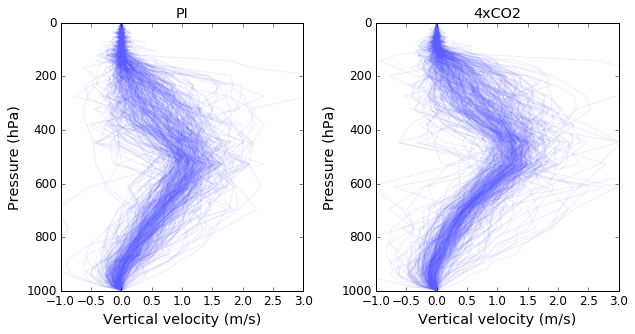

In [132]:
pr_id = "CRM_PREC_I50"
area_id = "I50"
q_id = "999000"
Q_id = "99.9"
w_id = "CRM_W_%s"%area_id

print "Get all w profiles..."
w_profiles_PI = w_profiles[experiment_PI][pr_id][q_id][w_id]
w_profiles_4xCO2 = w_profiles[experiment_4xCO2][pr_id][q_id][w_id]

print "Get mean pressure profiles..."
ps_PI = df_meanAtQ[compset_SPCAM][experiment_PI][subset_all][ps_id][pr_id][Q_id][0]
p_PI = computeP(ps_PI)
ps_4xCO2 = df_meanAtQ[compset_SPCAM][experiment_4xCO2][subset_all][ps_id][pr_id][Q_id][0]
p_4xCO2 = computeP(ps_4xCO2)

# Plot all profiles
fig, (ax0,ax1) = plt.subplots(ncols=2,nrows=1,figsize=(10,5))

for i in range(w_profiles_PI.shape[1]):
    ax0.plot(w_profiles_PI[:,i],p_PI/100.,alpha=0.1,c=col[pr_id])
    
for i in range(w_profiles_4xCO2.shape[1]):
    ax1.plot(w_profiles_4xCO2[:,i],p_4xCO2/100.,alpha=0.1,c=col[pr_id])

for ax in (ax0,ax1):    
    ax.invert_yaxis()
    ax.set_xlabel(r'Vertical velocity (m/s)')
    ax.set_ylabel(r'Pressure (hPa)')
    ax.set_xlim((-1,3))
    
ax0.set_title("PI")
ax1.set_title("4xCO2")

plt.show()

## Look at individual omega profiles 

Get all w profiles...
Get mean pressure profiles...


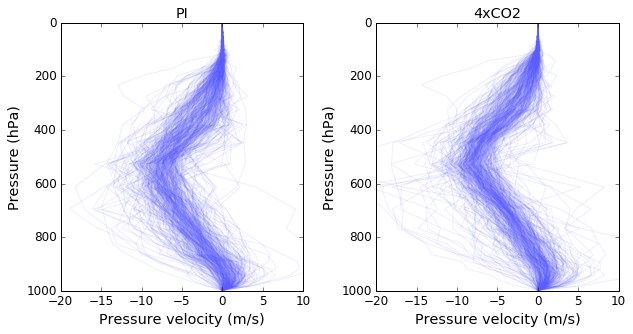

In [130]:
pr_id = "CRM_PREC_I50"
area_id = "I50"
q_id = "999000"
Q_id = "99.9"
w_id = "CRM_W_%s"%area_id
omega_id = "OMEGA_%s"%w_id

print "Get all w profiles..."
omega_profiles_PI = omega_profiles[experiment_PI][pr_id][q_id][omega_id]
omega_profiles_4xCO2 = omega_profiles[experiment_4xCO2][pr_id][q_id][omega_id]

print "Get mean pressure profiles..."
ps_PI = df_meanAtQ[compset_SPCAM][experiment_PI][subset_all][ps_id][pr_id][Q_id][0]
p_PI = computeP(ps_PI)
ps_4xCO2 = df_meanAtQ[compset_SPCAM][experiment_4xCO2][subset_all][ps_id][pr_id][Q_id][0]
p_4xCO2 = computeP(ps_4xCO2)

# Plot all profiles
fig, (ax0,ax1) = plt.subplots(ncols=2,nrows=1,figsize=(10,5))

for i in range(w_profiles_PI.shape[1]):
    ax0.plot(omega_profiles_PI[:,i],p_PI/100.,alpha=0.1,c=col[pr_id])
    
for i in range(w_profiles_4xCO2.shape[1]):
    ax1.plot(omega_profiles_4xCO2[:,i],p_4xCO2/100.,alpha=0.1,c=col[pr_id])

for ax in (ax0,ax1):    
    ax.invert_yaxis()
    ax.set_xlabel(r'Pressure velocity (m/s)')
    ax.set_ylabel(r'Pressure (hPa)')
    ax.set_xlim((-20,10))

ax0.set_title("PI")
ax1.set_title("4xCO2")

plt.show()

## PDF

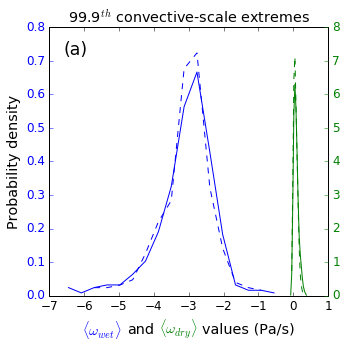

In [138]:
from matplotlib.offsetbox import AnchoredOffsetbox, TextArea, HPacker, VPacker
import copy

pr_ids_to_plot = ["CRM_PREC_I50"]
Q_ids_to_plot = ["999000"]
omega_ids_to_plot = ["OMEGA_CRM_W_I50","OMEGA_CRM_W_O50"]

bins = np.linspace(-7,0,num=20)
bins_dry = np.linspace(-1,2,num=100)
labels = {experiment_PI:"SPCAM_CTRL",experiment_4xCO2:"SPCAM_4xCO2"}
# labels = {experiment_PI:"Cold",experiment_4xCO2:"Warm"}

cols = 'b','g'
c = {omega_ids_to_plot[0]:cols[0],omega_ids_to_plot[1]:cols[1]}

fig, (ax0) = plt.subplots(ncols=1,nrows=1,figsize=(5,5))
ax0.tick_params('y', colors=cols[0])
ax1 = ax0.twinx()
ax1.tick_params('y', colors=cols[1])

ln = []
handles = []
p_profiles = {experiment_PI:p_PI,experiment_4xCO2:p_4xCO2}
for experiment in experiments:
    for pr_id in pr_ids_to_plot:
        for Q_id in Q_ids_to_plot:
            for omega_id in omega_ids_to_plot:
                
                dry = omega_id[-3:-2] == 'O'

                mf_values = [verticalPressureIntegral(p_profiles[experiment],omega)/verticalPressureIntegral(p_profiles[experiment]) \
                             for omega in np.swapaxes(omega_profiles[experiment][pr_id][Q_id][omega_id],0,1)]

                if not dry:
                    # Compute histograms
                    mf_Hd, mf_e = np.histogram(mf_values,bins=bins,density=True)
                    mf_Hd = mf_Hd/float(mf_Hd.sum())/np.diff(mf_e)[0]
    #                 mf_Hd = filter121(mf_Hd)
    #                 mf_Hd = filter121(filter121(mf_Hd))
                    mf_Hd[mf_Hd == 0] = None
                    mf_c = 0.5*(mf_e[:-1]+mf_e[1:])
                    # Plot
                    lab = "%s"%labels[experiment]
                    h = ax0.plot(mf_c,mf_Hd,linestyle=lt[experiment],c=c[omega_id],label=lab)
                    ln = ln + h
                    handles.append(copy.copy(h))
                else:
                    # Compute histograms
                    mf_Hd, mf_e = np.histogram(mf_values,bins=bins_dry,density=True)
                    mf_Hd = mf_Hd/float(mf_Hd.sum())/np.diff(mf_e)[0]
                    mf_Hd = filter121(filter121(mf_Hd))
                    mf_Hd[mf_Hd == 0] = None
                    mf_c = 0.5*(mf_e[:-1]+mf_e[1:])
                    # Plot
                    lab = "%s, dry area"%labels[experiment]
                    ax1.plot(mf_c,mf_Hd,linestyle=lt[experiment],c=c[omega_id],label=lab)


ax0.set_title(r"%2.1f$^{th}$ convective-scale extremes"%(float(Q_id)/10000.))
ax0.set_ylabel("Probability density")
ax0.set_xlim((-7,1))

### x-axis legend with colors
xbox1 = TextArea(r"$\langle\omega_{wet}\rangle$", textprops=dict(color=cols[0],size="x-large",ha='left',va='center'))
xbox2 = TextArea(r"and", textprops=dict(color="k",size="x-large",ha='left',va='center'))
xbox3 = TextArea(r"$\langle\omega_{dry}\rangle$", textprops=dict(color=cols[1],size="x-large",ha='left',va='center'))
xbox4 = TextArea(r"values (Pa/s)", textprops=dict(color="k",size="x-large",ha='left',va='center'))
xbox_list = [xbox1, xbox2, xbox3,xbox4]
# xbox_list = [xbox1, xbox4]

xbox = HPacker(children=xbox_list, align='baseline', pad=0, sep=5)

anchored_xbox = AnchoredOffsetbox(loc=8, child=xbox, pad=0., frameon=False, bbox_to_anchor=(0.5,-0.15), 
                                  bbox_transform=ax0.transAxes, borderpad=0.)
ax0.add_artist(anchored_xbox)

# ax0.set_yscale('log')
# ax1.set_yscale('log')

# cold = plt.Line2D((0,1),(0,0), color='k', linestyle='--')
# warm = plt.Line2D((0,1),(0,0), color='k')
# labs = (l.get_label() for l in ln)
# ax0.legend([cold,warm],labs,loc='upper left',handlelength=2,ncol=1,columnspacing=0.6,fontsize=12,framealpha=0.2,fancybox=True)

## Add letter label
trans2 = mtransforms.blended_transform_factory(ax0.transAxes, ax0.transAxes)
ax0.text(0.05,0.9,"(a)",fontsize='xx-large',transform=trans2)

plt.savefig(os.path.join(figdir,"fig_paper_DailyCRMmassfluxPDF_wet_and_dry_%s_%s_%s.pdf"%(q_id,string.join(pr_ids_to_plot,'_'),
                                                                             string.join(list(experiments),'_'))),
                        bbox_inches='tight')

In [ ]:
from matplotlib.offsetbox import AnchoredOffsetbox, TextArea, HPacker, VPacker

pr_ids_to_plot = ["CRM_PREC_I50"]

bins = np.linspace(-5,3,num=30)
# labels = {experiment_PI:"SPCAM_CTRL",experiment_4xCO2:"SPCAM_4xCO2"}
labels = {experiment_PI:"Cold",experiment_4xCO2:"Warm"}

c = {False:'b',True:'g'}

fig, (ax0) = plt.subplots(ncols=1,nrows=1,figsize=(5,5))
ax0.tick_params('y', colors=c[False])
ax1 = ax0.twinx()
ax1.tick_params('y', colors=c[True])

ln = []
mf_mean = {}
for pr_id in pr_ids_to_plot:
    mf_mean[pr_id] = {}
    for experiment in experiments:
        mf_mean[pr_id][experiment] = {}
        for dry in (False, True):
#         for dry in (False,):
            
            # Get mass flux values
        
            mf_means = computeCRMMF(mf_list,inc_list)
            mf_array = np.hstack(mf_means).squeeze()
            mf_mean[pr_id][experiment][dry] = mf_array.mean()
            print mf_array.mean()
            
            if not dry:
                # Compute histograms
                mf_Hd, mf_e = np.histogram(mf_array,bins=bins,density=True)
                mf_Hd = mf_Hd/float(mf_Hd.sum())
#                 mf_Hd = filter121(mf_Hd)
#                 mf_Hd = filter121(filter121(mf_Hd))
                mf_Hd[mf_Hd == 0] = None
                mf_c = 0.5*(mf_e[:-1]+mf_e[1:])
                # Plot
                lab = "%s, wet area"%labels[experiment]
                ln = ln + ax0.plot(mf_c,mf_Hd,linestyle=lt[experiment],c=c[dry],label=lab)
            else:
                # Compute histograms
                mf_Hd, mf_e = np.histogram(mf_array,bins=bins_dry,density=True)
                mf_Hd = mf_Hd/float(mf_Hd.sum())
                mf_Hd = filter121(filter121(mf_Hd))
                mf_Hd[mf_Hd == 0] = None
                mf_c = 0.5*(mf_e[:-1]+mf_e[1:])
                # Plot
                lab = "%s, dry area"%labels[experiment]
                ln = ln + ax1.plot(mf_c,mf_Hd,linestyle=lt[experiment],c=c[dry],label=lab)
                
ax0.set_xlim((-4,1))
ax0.set_title("Convective-scale mass fluxes for $P_{CRM}^{99.9}$")
ax0.set_ylabel("Frequency (%)")
# ax1.set_ylabel("Averaged over the dry region",color=c[True])

### x-axis legend with colors
xbox1 = TextArea(r"$\langle\omega_{wet}\rangle$", textprops=dict(color=c[False],size="x-large",ha='left',va='center'))
xbox2 = TextArea(r"and", textprops=dict(color="k",size="x-large",ha='left',va='center'))
xbox3 = TextArea(r"$\langle\omega_{dry}\rangle$", textprops=dict(color=c[True],size="x-large",ha='left',va='center'))
xbox4 = TextArea(r"values (Pa/s)", textprops=dict(color="k",size="x-large",ha='left',va='center'))

xbox = HPacker(children=[xbox1, xbox2, xbox3,xbox4], align='baseline', pad=0, sep=5)

anchored_xbox = AnchoredOffsetbox(loc=8, child=xbox, pad=0., frameon=False, bbox_to_anchor=(0.5,-0.15), 
                                  bbox_transform=ax0.transAxes, borderpad=0.)
ax0.add_artist(anchored_xbox)

labs = (l.get_label() for l in ln)
ax0.legend(ln, labs, loc='upper left',handlelength=2,ncol=1,columnspacing=0.6,fontsize=12)

# Compute mass flux contribution
dts = 4.223114014
print "Mass flux contribution:", (mf_mean["CRM_PREC_I50"][experiment_4xCO2][False]/mf_mean["CRM_PREC_I50"][experiment_PI][False] - 1.)*100./dts

plt.savefig(os.path.join(figdir,"fig_paper_DailyCRMmassfluxPDF_wet_and_dry_%s_%s_%s.pdf"%(q_id,string.join(pr_ids_to_plot,'_'),
                                                                             string.join(list(experiments),'_'))),
                        bbox_inches='tight')